<a href="https://colab.research.google.com/github/iamwendellbalagot/google-colab/blob/master/Pytorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
 
import time
import os
import copy
 
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
plt.ion()

In [ ]:
#data transformations
data_transforms = {
    'train': transforms.Compose([
      # transforms.RandomResizedCrop(224),
      # transforms.RandomHorizontalFlip(),
      transforms.Resize((256,256)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
      transforms.Resize((256,256)),
      # transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = 4,
                                              shuffle = True, num_workers = 4)
               for x in ['train', 'val']}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(dataset_sizes)
print(device)

{'train': 244, 'val': 153}
cuda:0


In [ ]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp);
  if title is not None:
    plt.title(title);


Transpose (260, 1034, 3) 

Mean, STD:  (260, 1034, 3) 

Clip:  (260, 1034, 3) 



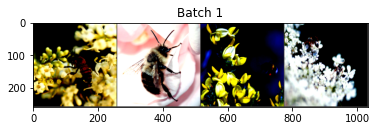

In [ ]:
images, labels = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images)

imshow(out, 'Batch 1')

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('=' *20)

    for phase in ['train', 'val']:

      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        #stats
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step()
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
      
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best Validation Accuracy: {}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(inputs.shape)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                print(classes[preds[j]])
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)

In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion_ft, optimizer_ft, exp_lr_scheduler, num_epochs=25)

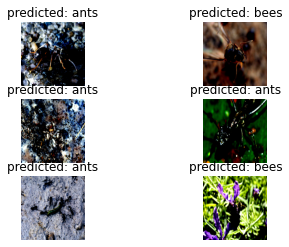

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = models.resnet18(pretrained=True)

for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion_conv = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
model_conv = train_model(model_conv, criterion_conv, optimizer_conv, exp_lr_scheduler)

torch.Size([4, 3, 256, 256])
bees
ants
ants
ants
torch.Size([4, 3, 256, 256])
bees
bees


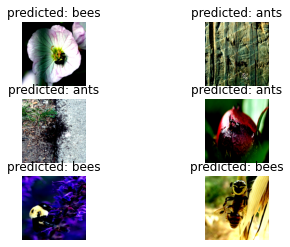

In [ ]:
visualize_model(model_conv)

bees


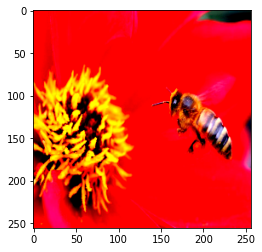

In [ ]:
images, labels = next(iter(dataloaders['val']))
samp_image = images[0].view(1,3,256,256)
samp_image = samp_image.to(device)
print(classes[torch.max(model_conv(samp_image), 1)[1]])

imshow(samp_image.view(3,256,256).cpu());